In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import ode
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline

In [2]:
def create_cmap(color1, color2, color3):
    colors = [color1, color2, color3]
    cmap_name = 'list'
    n_bins = 100
    cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
    return cmap

def lorenz(t, state, par): 
    σ, ρ, β = par
    x, y, z = state
    ẋ = σ * (y - x)
    ẏ = (x * (ρ - z)) - y
    ż = (x * y) - (β * z)
    dx = np.array((ẋ, ẏ, ż))
    return dx

def get_lorenz_data(tspan):
    σ, ρ, β = 10, 28, 8 / 3 # chaotic parameters 
    initial = np.array([-8, 8, 27]) # initial condition 
    data = np.empty((3, len(tspan)))
    data[:, 0] = initial
    r = ode(lorenz).set_integrator('dopri5')
    r.set_initial_value(initial, tspan[0])
    r.set_f_params((σ, ρ, β))
    for i, t in enumerate(tspan):
        if i == 0:
            continue
        r.integrate(t)
        data[:, i] = r.y
    return data 

def build_hankel(data, rows, cols):
    X = np.empty((rows, cols))
    for k in range(rows):
        X[k, :] = data[k:cols + k]
    return X 

def HAVOK(X, dt, r, norm, center=False, return_uv=False):
    if (center): 
        m = X.shape[0]
        X̄ = X - X[m//2,:]
        U, Σ, Vh = np.linalg.svd(X̄,full_matrices=False)
    else:
        U, Σ, Vh = np.linalg.svd(X,full_matrices=False)
    V = Vh.T
    polys = true_polys(X.shape[0], dt, r, center)
    for _i in range(r):
        if (np.dot(U[:,_i], polys[:,_i]) < 0):
            U[:,_i] *= -1
            V[:,_i] *= -1
    V1 = V[:-1,:r]
    V2 = V[1:,:r]
    A = (V2.T @ np.linalg.pinv(V1.T) - np.eye(r)) / (norm * dt)
    if (return_uv): 
        return A, U, V
    return A

def true_polys(rows, dt, r, center): 
    m = rows // 2
    Ut = np.linspace(-m*dt, m*dt, rows)
    poly_stack = []
    for j in range(r):
        if (center):
            poly_stack.append(Ut ** (j + 1))
        else: 
            poly_stack.append(Ut ** j)
    poly_stack = np.vstack(poly_stack).T
    Q = np.empty((rows, r)) # Perform Gram-Schmidt
    for j in range(r): 
        v = poly_stack[:, j]
        for k in range(j - 1): 
            r_jk = Q[:, k].T @ poly_stack[:, j]
            v -= (r_jk * Q[:, k])
        r_jj = np.linalg.norm(v)
        Q[:, j] = v / r_jj
    return Q

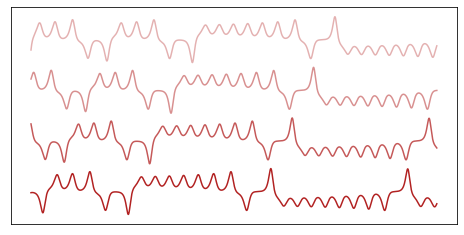

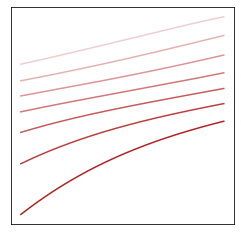

In [3]:
dt = 0.0001
tmin = 0.0
tmax = 22.0
tspan = np.arange(tmin, tmax + dt, dt)
data = get_lorenz_data(tspan)

col = 'firebrick'
plt.figure(figsize=(8,4))
plt.plot(data[0,int(3e4):] + 0, col, alpha=1)
plt.plot(data[0,int(2e4):-int(1e4)] + 40, col, alpha=0.75)
plt.plot(data[0,int(1e4):-int(2e4)] + 80, col, alpha=0.5)
plt.plot(data[0,:-int(3e4)] + 120, col, alpha=0.35)
plt.xticks([])
plt.yticks([])
plt.savefig('pdf_files/fig3a.pdf',bbox_inches = "tight")

plt.figure(figsize=(4,4))
for i in range(7):
    plt.plot(data[0,i*400:i*400+1000], col, alpha=1-i*.13)
plt.xticks([])
plt.yticks([])
# plt.axis('off')
plt.savefig('pdf_files/fig3b.pdf',bbox_inches = "tight")

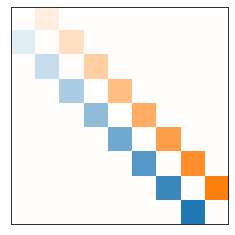

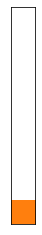

In [4]:
# Linear dynamics
np.random.seed(4)
plt.figure()
vals = np.array([1, 2, 3, 4, 5, 6, 7, 8])
plt.imshow(np.diag(vals,1) + np.diag(-vals,-1), cmap=create_cmap('tab:blue','white','tab:orange'))
plt.xticks([])
plt.yticks([])
plt.savefig('pdf_files/fig3c.pdf', bbox_inches='tight')

# Forcing 
np.random.seed(4)
plt.figure()
a = np.zeros(9)
a[-1] = 10
plt.imshow(a[:,np.newaxis], cmap=create_cmap('white','tab:blue','tab:orange'))
plt.xticks([])
plt.yticks([])
plt.savefig('pdf_files/fig3d.pdf', bbox_inches='tight')

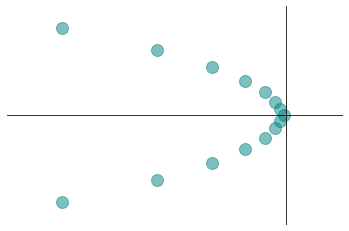

In [5]:
# Plot eigenvalues 
dt = 0.001 
samples = int(300000)
tspan = np.arange(samples) * dt
xdata = get_lorenz_data(tspan)[0,:]
rows = 201
cols = xdata.size - rows + 1
X = build_hankel(xdata, rows, cols)
A = HAVOK(X, dt, 15, 1)
ω = np.linalg.eig(A)[0]

ax = plt.subplot(1, 1, 1)
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
plt.xticks([])
plt.yticks([])
plt.plot(ω.real, ω.imag, 'o', color='teal', markersize=12, label='true', alpha=0.5)
plt.xlim([-6, 1.2])
plt.ylim([-120, 120])
plt.savefig('pdf_files/fig3e.pdf', bbox_inches='tight')